# Notebook to generate graphics combining multiple models

## Load data

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

In [4]:
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/"
model_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)
dataset_names = sorted(
    [
        d
        for d in os.listdir(log_dir + "/convnext_bs")
        if os.path.isdir(os.path.join(log_dir + "/convnext_bs", d))
    ]
)


# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for model in model_names:
    data[model] = {}

    for i, ds in enumerate(dataset_names):
        data[model][ds] = {}
        color_idx = available_indices[i % len(available_indices)]
        dataset_colors[ds] = colors(color_idx)

        ds_path = os.path.join(log_dir, model, ds)
        pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
        if not pkl_files:
            continue
        # pick most recent file
        pkl_files.sort(
            key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
        )
        file_path = os.path.join(ds_path, pkl_files[0])
        preds, t, metadata = load_dump(file_path)
        data[model][ds]["predictions"] = preds
        data[model][ds]["targets"] = t.int()
        data[model][ds]["metadata"] = metadata
        data[model][ds]["color"] = dataset_colors[ds]

# concatenate
valid_dataset_names = [
    (model, ds)
    for model, datasets in data.items()
    for ds, v in datasets.items()
    if isinstance(v, dict)
    and "predictions" in v
    and "targets" in v
    and isinstance(v["predictions"], torch.Tensor)
    and isinstance(v["targets"], torch.Tensor)
]

if not valid_dataset_names:
    raise ValueError("No datasets with both 'predictions' and 'targets' present.")

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilab

In [5]:
model_colors = {
    "convnext_bs": "red",
    "birdmae": "blue",
    "audioprotopnet": "green",
    "perch_v2": "orange",
}

In [6]:
targets = torch.cat(
    [data["convnext_bs"][ds]["targets"] for _, ds in valid_dataset_names], dim=0
)
# present targets
targets_present = targets.sum(dim=0).gt(0)

### Only select datasets with both predictions and targets

In [7]:
# only select classes with target labels
for model in model_names:
    for key in list(data[model].keys()):
        # keep the dict structure; only replace the predictions/targets tensors
        data[model][key]["predictions"] = data[model][key]["predictions"][
            :, targets_present
        ]
        data[model][key]["targets"] = data[model][key]["targets"][:, targets_present]
    # metadata and color remain unchanged

In [8]:
# add combined predictions/targets for each model
from uncertainbird.utils.plotting import print_metrics


for model in model_names:
    all_preds = torch.cat(
        [data[model][ds]["predictions"] for _, ds in valid_dataset_names], dim=0
    )
    all_tars = torch.cat(
        [data[model][ds]["targets"] for _, ds in valid_dataset_names], dim=0
    )
    data[model]["combined"] = {
        "predictions": all_preds,
        "targets": all_tars,
        "metrics": print_metrics(all_preds, all_tars),
        "metadata": None,
        "color": model_colors.get(model, "black"),
    }

Accuracy: tensor(0.9985)
cmAP: tensor(0.3062)
Precision: tensor(0.4709)
Recall: tensor(0.1555)
F1 Score: tensor(0.1856)
AUROC: tensor(0.9541)
ECE: tensor(0.1310)
ECE Weighted: tensor(0.1298)
ECE Top-3: tensor(0.1195)
ECE Top-5: tensor(0.1244)
ECE Top-10: tensor(0.1343)
ECE Top-21: tensor(0.1325)
Miscalibration Score (MCS): tensor(0.1247)
ECE Under-confidence: tensor(0.0026)
ECE Over-confidence: tensor(0.1273)
Accuracy: tensor(0.9985)
cmAP: tensor(0.2549)
Precision: tensor(0.3916)
Recall: tensor(0.1854)
F1 Score: tensor(0.2017)
AUROC: tensor(0.8881)
ECE: tensor(0.1774)
ECE Weighted: tensor(0.1818)
ECE Top-3: tensor(0.1658)
ECE Top-5: tensor(0.1773)
ECE Top-10: tensor(0.1818)
ECE Top-21: tensor(0.1876)
Miscalibration Score (MCS): tensor(0.1777)
ECE Under-confidence: tensor(0.0020)
ECE Over-confidence: tensor(0.1798)
Accuracy: tensor(0.9984)
cmAP: tensor(0.2337)
Precision: tensor(0.4269)
Recall: tensor(0.1034)
F1 Score: tensor(0.1359)
AUROC: tensor(0.9092)
ECE: tensor(0.0016)
ECE Weighted

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.bucketize(confidences, bin_boundaries, right=True) - 1


Accuracy: tensor(0.9986)
cmAP: tensor(0.3922)
Precision: tensor(0.5418)
Recall: tensor(0.1408)
F1 Score: tensor(0.1951)
AUROC: tensor(0.9655)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.0076)
ECE Top-3: tensor(0.0246)
ECE Top-5: tensor(0.0189)
ECE Top-10: tensor(0.0137)
ECE Top-21: tensor(0.0092)
Miscalibration Score (MCS): tensor(-0.0071)
ECE Under-confidence: tensor(0.0074)
ECE Over-confidence: tensor(0.0002)


In [9]:
model_mapping = {
    "convnext_bs": "ConvNeXt$_{BS}$",
    "birdmae": "BirdMAE",
    "audioprotopnet": "AudioProtoPNet",
    "perch_v2": "Perch v2",
}

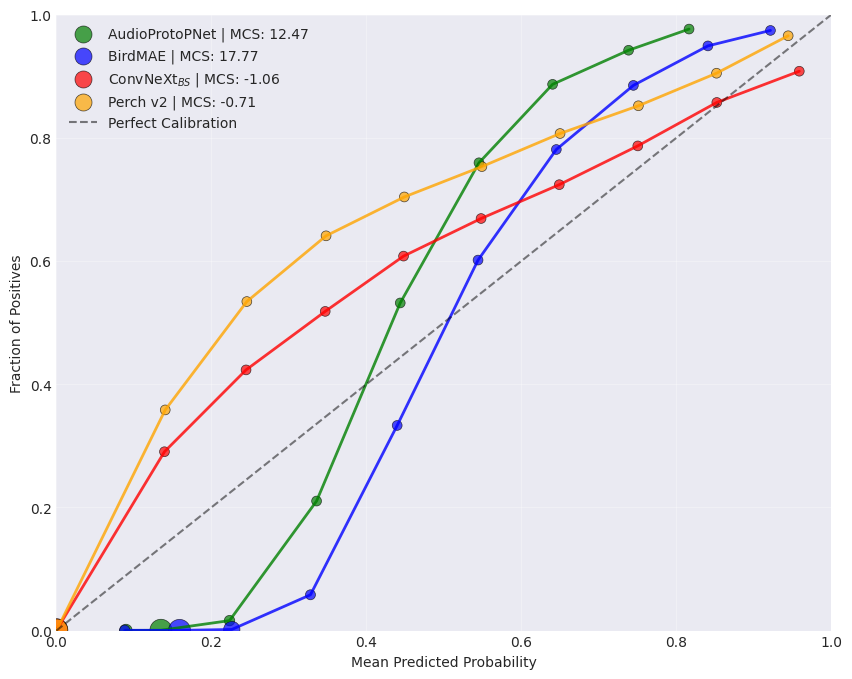

In [10]:
# plot reliability diagram for each model
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# preprocess data such that it has the format data[<model_name>]

data_for_plot = {model_mapping[model]: data[model]["combined"] for model in model_names}
plot_combined_reliability_diagram(
    data_for_plot,
    title=None,
)
# save as pdf under 500dpi at /workspace/projects/uncertainbird/results/reliability-combined.pdf
# increase font size to 10
plt.rcParams.update({"font.size": 24})
# set width to 250pixels
plt.rcParams["figure.figsize"] = [3.459, 3.459]
plt.savefig(
    "/workspace/projects/uncertainbird/results/reliability-combined.pdf", dpi=500
)
plt.show()

## Per class

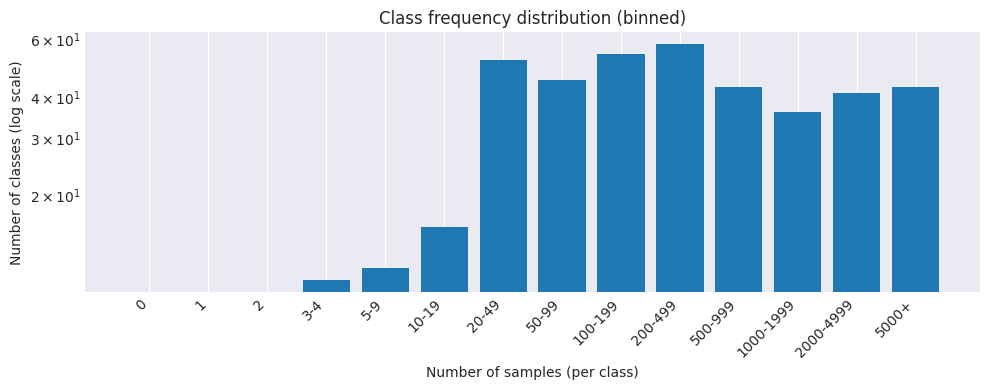

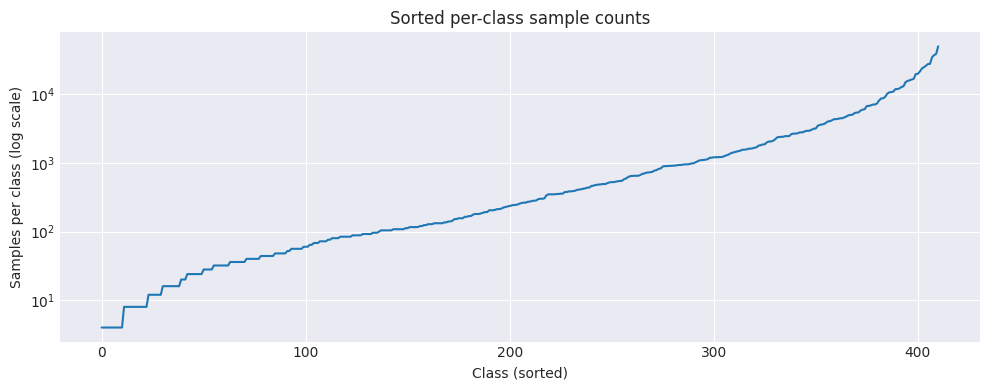

In [11]:
from uncertainbird.utils.plotting import plot_class_frequency

plt.rcParams.update({"font.size": 10})
# set width to 250pixels
plt.rcParams["figure.figsize"] = [3.459, 3.459]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]
plot_class_frequency(targets_targetclasses)

Number of classes covering 50% of all samples: 19


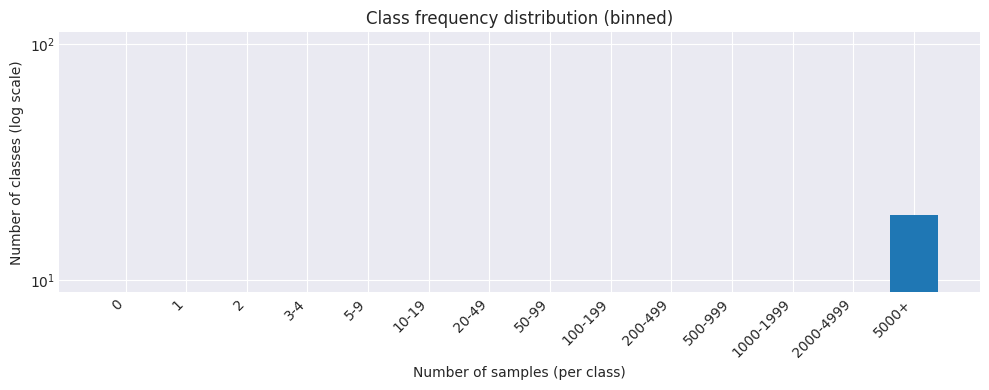

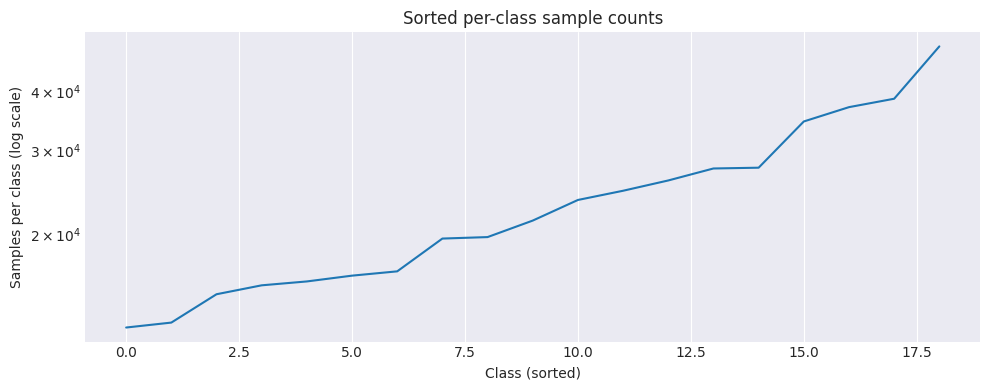

In [12]:
# select classes with most samples such that 50% of all samples are covered
class_counts = targets_targetclasses.sum(dim=0)  # torch tensor
sorted_indices = torch.argsort(class_counts, descending=True)  # no negative strides
cumulative_counts = torch.cumsum(class_counts[sorted_indices], dim=0)
total_counts = cumulative_counts[-1]
threshold = total_counts * 0.5
# first index where cumulative >= threshold
num_classes_50_percent = int(
    (cumulative_counts >= threshold).nonzero(as_tuple=True)[0][0].item() + 1
)
print(f"Number of classes covering 50% of all samples: {num_classes_50_percent}")
selected_indices = sorted_indices[:num_classes_50_percent]
targets_top = targets_targetclasses[:, selected_indices]
plot_class_frequency(targets_top)

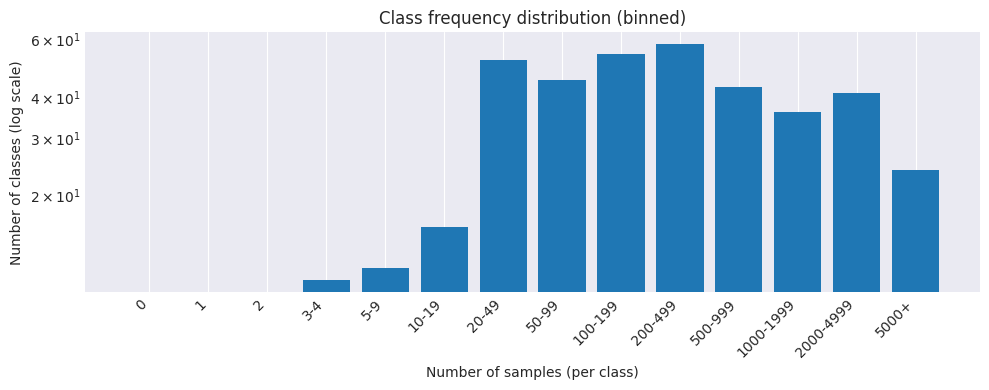

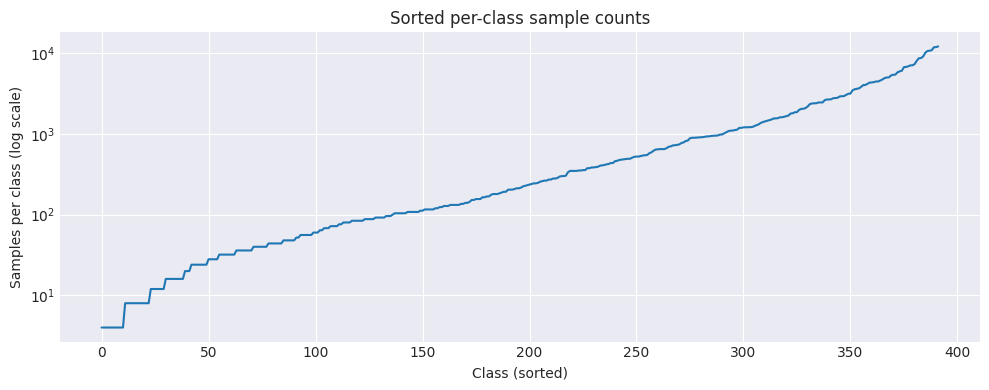

In [13]:
# select the other classes
targets_other = targets_targetclasses[:, sorted_indices[num_classes_50_percent:]]
plot_class_frequency(targets_other)

In [14]:
# preprocess data such that it has the format data[<model_name>]

# build data_for_plot with separate entries for top (50% coverage) and other classes
top_indices = selected_indices
other_indices = sorted_indices[num_classes_50_percent:]

data_for_plot = {}
for model in model_names:
    base_name = model_mapping[model]
    preds = data[model]["combined"]["predictions"]
    tars = data[model]["combined"]["targets"]

    top_preds = preds[:, top_indices]
    top_tars = tars[:, top_indices]
    other_preds = preds[:, other_indices]
    other_tars = tars[:, other_indices]

    data_for_plot[f"{base_name} Top"] = {
        "predictions": top_preds,
        "targets": top_tars,
        "metrics": print_metrics(top_preds, top_tars),
        "metadata": None,
        "color": model_colors.get(model, "black"),
    }
    data_for_plot[f"{base_name} Other"] = {
        "predictions": other_preds,
        "targets": other_tars,
        "metrics": print_metrics(other_preds, other_tars),
        "metadata": None,
        "color": model_colors.get(model, "black"),
    }

Accuracy: tensor(0.9839)
cmAP: tensor(0.6415)
Precision: tensor(0.8758)
Recall: tensor(0.1611)
F1 Score: tensor(0.2442)
AUROC: tensor(0.9671)
ECE: tensor(0.1347)
ECE Weighted: tensor(0.1329)
ECE Top-3: tensor(0.1195)
ECE Top-5: tensor(0.1244)
ECE Top-10: tensor(0.1343)
ECE Top-21: tensor(0.1347)
Miscalibration Score (MCS): tensor(0.1239)
ECE Under-confidence: tensor(0.0045)
ECE Over-confidence: tensor(0.1284)
Accuracy: tensor(0.9992)
cmAP: tensor(0.2899)
Precision: tensor(0.4513)
Recall: tensor(0.1552)
F1 Score: tensor(0.1828)
AUROC: tensor(0.9535)
ECE: tensor(0.1308)
ECE Weighted: tensor(0.1267)
ECE Top-3: tensor(0.1159)
ECE Top-5: tensor(0.1066)
ECE Top-10: tensor(0.1173)
ECE Top-21: tensor(0.1232)
Miscalibration Score (MCS): tensor(0.1256)
ECE Under-confidence: tensor(0.0005)
ECE Over-confidence: tensor(0.1261)
Accuracy: tensor(0.9850)
cmAP: tensor(0.6015)
Precision: tensor(0.8188)
Recall: tensor(0.2626)
F1 Score: tensor(0.3582)
AUROC: tensor(0.9318)
ECE: tensor(0.1896)
ECE Weighted

In [15]:
# use light color for "Other" classes and dark color for "Top" classes
import matplotlib.colors as mcolors

for key in list(data_for_plot.keys()):
    if "Other" in key:
        base_key = key.replace(" Other", " Top")
        base_color = data_for_plot.get(base_key, {}).get("color", "black")
        # Convert to RGB
        base_rgb = mcolors.to_rgb(base_color)
        # Lighten by moving 50% toward white
        light_rgb = tuple(c + (1.0 - c) * 0.5 for c in base_rgb)
        data_for_plot[key]["color"] = light_rgb
    else:
        # Normalize stored color to an RGB tuple (keeps original tone)
        data_for_plot[key]["color"] = mcolors.to_rgb(data_for_plot[key]["color"])

In [16]:
# replace in model name Top with $\arrowup$ and Other with $\arrowdown$
for key in list(data_for_plot.keys()):
    if "Top" in key:
        new_key = key.replace(" Top", " $\u2191$")
        data_for_plot[new_key] = data_for_plot.pop(key)
    elif "Other" in key:
        new_key = key.replace(" Other", " $\u2193$")
        data_for_plot[new_key] = data_for_plot.pop(key)

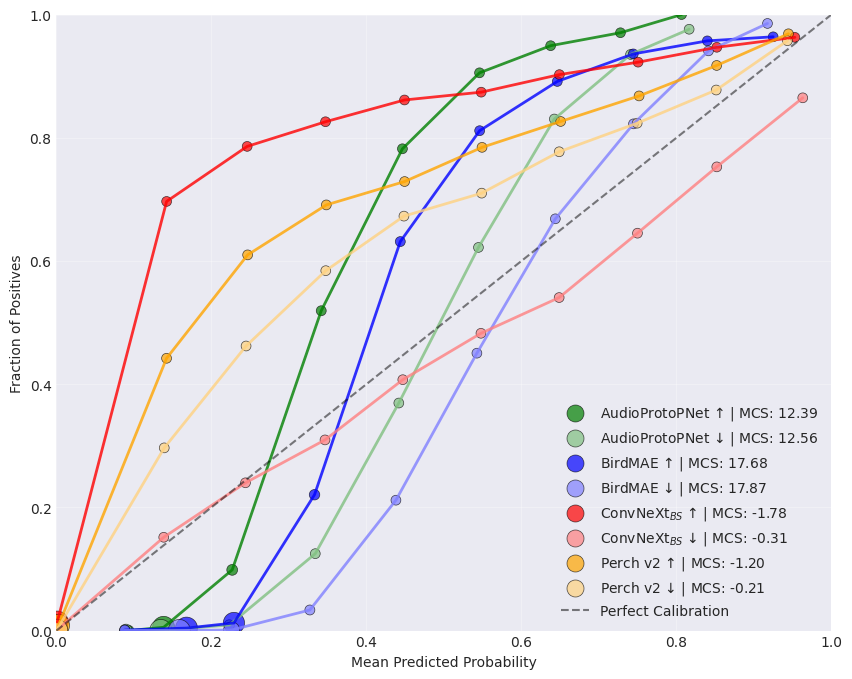

In [17]:
plot_combined_reliability_diagram(
    data_for_plot,
    title=None,
)


plt.savefig(
    "/workspace/projects/uncertainbird/results/reliability-top-bottom.pdf", dpi=500
)
plt.show()

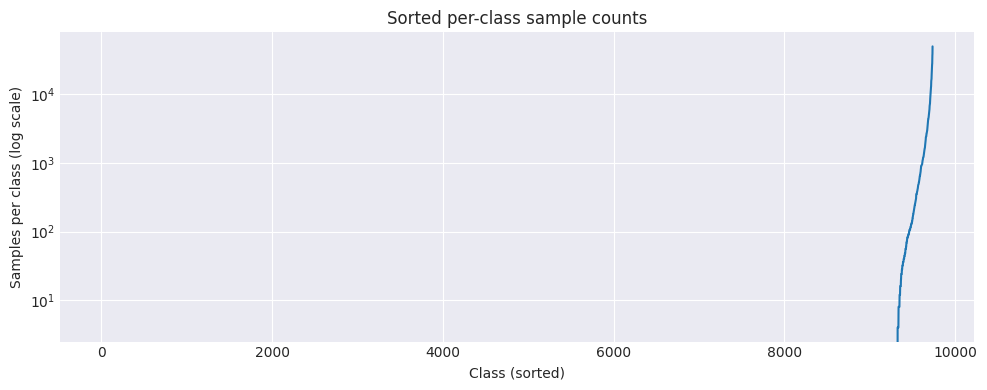

In [18]:
# show what classes belong to the top and other groups by plotting the sorted class frequencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Per-class sample counts (multilabel: sum over samples axis)
class_counts = targets.sum(dim=0).cpu().numpy().astype(int)

# Sort counts (optional diagnostic)
sorted_counts = np.sort(class_counts)

# Sorted counts (already log scale)
plt.figure(figsize=(10, 4))
plt.plot(sorted_counts)
plt.ylabel("Samples per class (log scale)")
plt.xlabel("Class (sorted)")
plt.title("Sorted per-class sample counts")
plt.yscale("log")
plt.tight_layout()
plt.show()

### ECE vs sample count

In [27]:
model_names

['audioprotopnet', 'birdmae', 'convnext_bs', 'perch_v2']

In [29]:
from uncertainbird.utils.misc import class_wise_statistics

for model in model_names:
    # calculate class-wise statistics
    data[model]["class_stats"] = class_wise_statistics(
        data[model]["combined"]["predictions"].float(),
        data[model]["combined"]["targets"].int(),
        n_bins=10,
    )

In [30]:
data["convnext_bs"]["class_stats"]

{'mean': tensor([5.9473e-04, 3.5590e-04, 6.8503e-04, 5.8305e-04, 2.1509e-03, 3.9398e-05,
         1.6297e-05, 4.8115e-03, 2.6989e-04, 1.3080e-04, 8.0534e-04, 3.8623e-03,
         1.4223e-04, 1.0916e-04, 2.5828e-04, 3.1691e-05, 2.6905e-04, 4.6626e-04,
         3.2568e-05, 9.3398e-04, 1.5806e-05, 7.7022e-05, 1.0979e-04, 4.9669e-05,
         1.7916e-04, 4.4260e-04, 1.8841e-04, 1.9624e-05, 1.1419e-05, 7.7774e-05,
         1.1813e-03, 4.2356e-04, 8.0071e-04, 5.8364e-04, 9.4104e-04, 6.6248e-05,
         4.4679e-04, 1.0330e-04, 1.1847e-04, 4.9969e-04, 2.2410e-04, 4.5065e-04,
         1.6895e-03, 3.8344e-04, 3.3486e-04, 7.4361e-04, 5.7680e-04, 1.5582e-03,
         1.4818e-04, 3.1295e-04, 3.7440e-04, 4.3652e-04, 4.4728e-04, 2.2092e-04,
         9.2190e-05, 9.4198e-05, 2.0812e-06, 6.8150e-05, 5.6717e-03, 4.3358e-05,
         4.2150e-04, 5.7257e-04, 1.2798e-04, 1.6344e-03, 3.8981e-06, 1.1139e-03,
         1.1971e-04, 1.4366e-04, 3.9242e-04, 4.5545e-04, 1.4558e-03, 5.4169e-04,
         1.9559e-04,

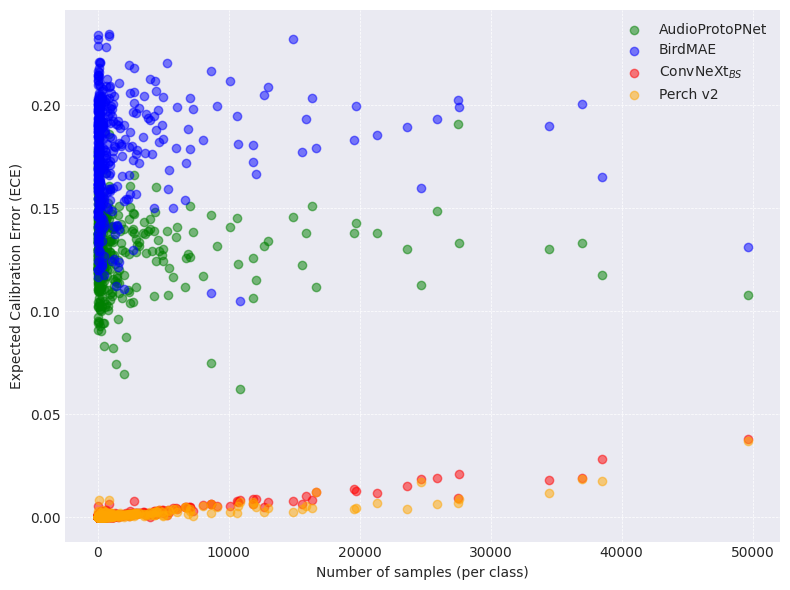

In [33]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
# iterate only over the selected models
for model in [
    m
    for m in model_names
    if m in ["convnext_bs", "birdmae", "audioprotopnet", "perch_v2"]
]:
    stats = data.get(model, {}).get("class_stats", {})
    x = stats.get("positive_samples")
    y = stats.get("ece")
    if x is None or y is None:
        # skip if statistics are not available
        continue
    # convert torch tensors to numpy for plotting if necessary
    if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().numpy()

    plt.scatter(
        x,
        y,
        alpha=0.5,
        color=model_colors.get(model, "black"),
        label=model_mapping.get(model, model),
    )

plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
# plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
# legend
plt.legend()
plt.tight_layout()
# save as pdf under 500dpi at /workspace/projects/uncertainbird/results/ece-vs-sample-count.pdf
# increase font size to 24
plt.rcParams.update({"font.size": 24})
# set width to 250pixels
plt.rcParams["figure.figsize"] = [3.459, 3.459]
plt.savefig(
    "/workspace/projects/uncertainbird/results/ece-vs-sample-count.pdf", dpi=500
)
plt.show()

## Per dataset

In [37]:
# print color for each model
for model in model_names:
    print(f"{model}: {model_colors.get(model, 'black')}")

audioprotopnet: green
birdmae: blue
convnext_bs: red
perch_v2: orange


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9944)
cmAP: tensor(0.3161)
Precision: tensor(0.1501)
Recall: tensor(0.0227)
F1 Score: tensor(0.0354)
AUROC: tensor(0.2597)
ECE: tensor(0.1478)
ECE Weighted: tensor(0.1513)
ECE Top-3: tensor(0.1406)
ECE Top-5: tensor(0.1328)
ECE Top-10: tensor(0.1402)
ECE Top-21: tensor(0.1451)
Miscalibration Score (MCS): tensor(0.0617)
ECE Under-confidence: tensor(0.0448)
ECE Over-confidence: tensor(0.1065)
Accuracy: tensor(0.9944)
cmAP: tensor(0.2526)
Precision: tensor(0.1451)
Recall: tensor(0.0299)
F1 Score: tensor(0.0426)
AUROC: tensor(0.2414)
ECE: tensor(0.1772)
ECE Weighted: tensor(0.1810)
ECE Top-3: tensor(0.1665)
ECE Top-5: tensor(0.1497)
ECE Top-10: tensor(0.1786)
ECE Top-21: tensor(0.1882)
Miscalibration Score (MCS): tensor(0.1210)
ECE Under-confidence: tensor(0.0300)
ECE Over-confidence: tensor(0.1510)
Accuracy: tensor(0.9941)
cmAP: tensor(0.1784)
Precision: tensor(0.1092)
Recall: tensor(0.0133)
F1 Score: tensor(0.0189)
AUROC: tensor(0.2333)
ECE: tensor(0.0058)
ECE Weighted

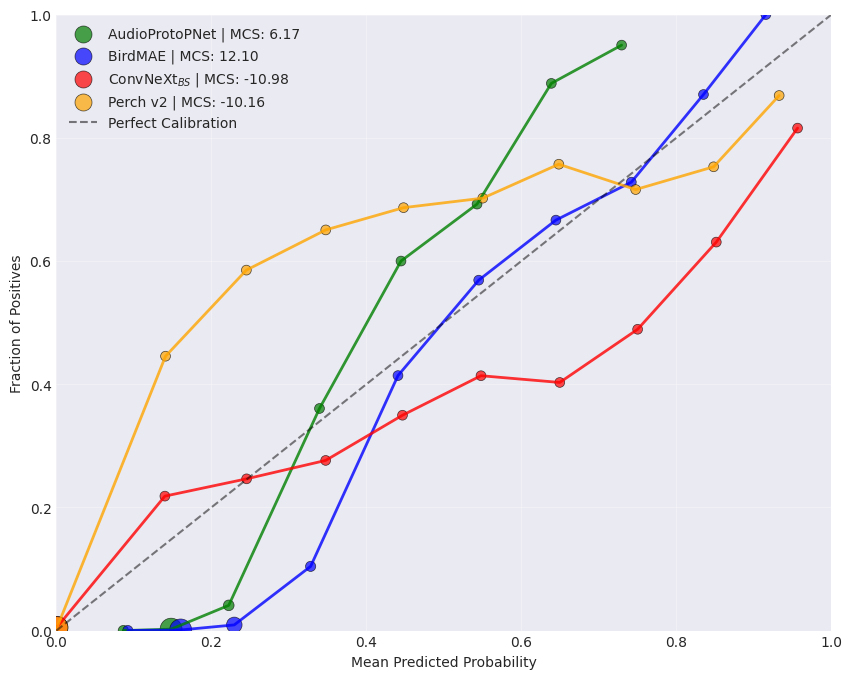

In [45]:
# plot reliability diagram for each model for the PER dataset

# preprocess data such that it has the format data[<model_name>]

data_for_plot = {}
for model in model_names:
    entry = data[model].get("PER")
    if entry is None:
        continue
    # reuse predictions/targets but create a shallow copy so we don't mutate original
    new_entry = {
        "predictions": entry["predictions"],
        "targets": entry["targets"],
        "metadata": entry.get("metadata"),
        # use existing metrics if present, otherwise compute
        "metrics": entry.get(
            "metrics", print_metrics(entry["predictions"], entry["targets"])
        ),
        "color": model_colors.get(model, "black"),
    }
    data_for_plot[model_mapping[model]] = new_entry
plot_combined_reliability_diagram(
    data_for_plot,
    title=None,
)
# save as pdf under 500dpi at /workspace/projects/uncertainbird/results/reliability-combined.pdf
# increase font size to 10
plt.rcParams.update({"font.size": 10})
# set width to 250pixels
plt.rcParams["figure.figsize"] = [3.459, 3.459]
plt.savefig("/workspace/projects/uncertainbird/results/reliability-PER.pdf", dpi=500)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9939)
cmAP: tensor(0.5047)
Precision: tensor(0.0748)
Recall: tensor(0.0253)
F1 Score: tensor(0.0304)
AUROC: tensor(0.1039)
ECE: tensor(0.1550)
ECE Weighted: tensor(0.2417)
ECE Top-3: tensor(0.2787)
ECE Top-5: tensor(0.2326)
ECE Top-10: tensor(0.1963)
ECE Top-21: tensor(0.1835)
Miscalibration Score (MCS): tensor(-0.0692)
ECE Under-confidence: tensor(0.1554)
ECE Over-confidence: tensor(0.0862)
Accuracy: tensor(0.9943)
cmAP: tensor(0.3955)
Precision: tensor(0.0712)
Recall: tensor(0.0225)
F1 Score: tensor(0.0285)
AUROC: tensor(0.0970)
ECE: tensor(0.1555)
ECE Weighted: tensor(0.2210)
ECE Top-3: tensor(0.2275)
ECE Top-5: tensor(0.1975)
ECE Top-10: tensor(0.1783)
ECE Top-21: tensor(0.1902)
Miscalibration Score (MCS): tensor(-0.0272)
ECE Under-confidence: tensor(0.1241)
ECE Over-confidence: tensor(0.0969)
Accuracy: tensor(0.9940)
cmAP: tensor(0.3357)
Precision: tensor(0.0520)
Recall: tensor(0.0084)
F1 Score: tensor(0.0128)
AUROC: tensor(0.0955)
ECE: tensor(0.0061)
ECE Weight

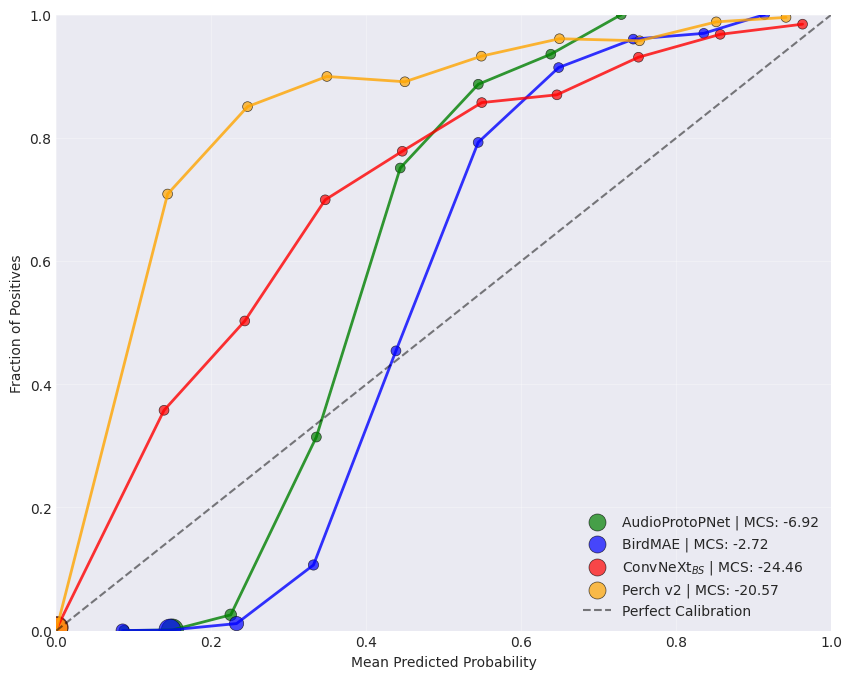

In [46]:
# plot reliability diagram for each model for the POW dataset

# preprocess data such that it has the format data[<model_name>]

data_for_plot = {}
for model in model_names:
    entry = data[model].get("POW")
    if entry is None:
        continue
    # reuse predictions/targets but create a shallow copy so we don't mutate original
    new_entry = {
        "predictions": entry["predictions"],
        "targets": entry["targets"],
        "metadata": entry.get("metadata"),
        # use existing metrics if present, otherwise compute
        "metrics": entry.get(
            "metrics", print_metrics(entry["predictions"], entry["targets"])
        ),
        "color": model_colors.get(model, "black"),
    }
    data_for_plot[model_mapping[model]] = new_entry
plot_combined_reliability_diagram(
    data_for_plot,
    title=None,
)
# save as pdf under 500dpi at /workspace/projects/uncertainbird/results/reliability-combined.pdf
# increase font size to 10
plt.rcParams.update({"font.size": 10})
# set width to 250pixels
plt.rcParams["figure.figsize"] = [3.459, 3.459]
plt.savefig("/workspace/projects/uncertainbird/results/reliability-POW.pdf", dpi=500)